<a href="https://colab.research.google.com/github/possomartin/Notebooks/blob/main/practica_aleatoriedad_g1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random walk on graphs

Think on a motivation on using graphs for modeling

- [The Structure and Function of Complex Networks](https://epubs.siam.org/doi/pdf/10.1137/S003614450342480)
- [Introduction to graph theory in networkx](https://towardsdatascience.com/an-intro-to-graph-theory-centrality-measurements-and-networkx-1c2e580adf37)
- [Random walks on graphs](https://graphstream-project.org/doc/Algorithms/Random-walks-on-graphs/)
- [Architecture as a graph](https://towardsdatascience.com/architecture-as-a-graph-6a835d46f918)
- [Network algorithms](https://towardsdatascience.com/10-graph-algorithms-visually-explained-e57faa1336f3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Random walk on a graph

Start at 0, go left with probability 1/2, go right with probability 1/2. Reflecting barrier at 0 - if particle hits 0, it must switch direction at next step and return to 1. Absorbing barrier at $n$ - particle stops when it hits state n. Estimate number of steps as a function of n until the particle is absorbed.
Analytic solution: $n^2$. Use $n \in \{2, 3, 4, 5,...,10\}$, where $n$ is the abosorbing barrier.

![](https://raw.githubusercontent.com/marsgr6/r-scripts/master/imgs/rwbarriers.png)

The state-transition diagram is shown below:

![](https://raw.githubusercontent.com/marsgr6/r-scripts/master/imgs/drunkards-walk.png)

- Check this resource on [absorbing markov chains](https://brilliant.org/wiki/absorbing-markov-chains/) and check also the [wiki entry](https://en.wikipedia.org/wiki/Absorbing_Markov_chain).

In [ ]:
from sympy import Matrix
n = 4
ds = [1] + [0.5]*(n-1)
Xs = np.diag(ds, 1)
di = [0.5]*(n-1) + [0]
Xi = np.diag(di, -1)
dd = [0]*n + [1]
Xd = np.diag(dd, 0)
Q = Xs + Xi + Xd
Matrix(Q)

Matrix([
[0.0, 1.0, 0.0, 0.0, 0.0],
[0.5, 0.0, 0.5, 0.0, 0.0],
[0.0, 0.5, 0.0, 0.5, 0.0],
[0.0, 0.0, 0.5, 0.0, 0.5],
[0.0, 0.0, 0.0, 0.0, 1.0]])

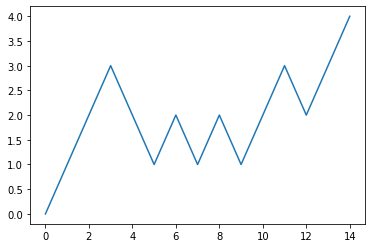

In [ ]:
states = list(range(n+1))
states
start = 0
walk = [start]

while(True):
    walk += [np.random.choice(states, p=Q[walk[-1]])]
    if walk[-1] == n: break
plt.plot(range(len(walk)), walk)

## Random shortest path

From the implementation above, how would you find a shortest path using random walks.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Shortest_path_with_direct_weights.svg/640px-Shortest_path_with_direct_weights.svg.png)

In [ ]:
neighbors = ['B', 'C']
weights = np.array([4, 2])
prob = 1 - weights / np.sum(weights)
neighbors, prob, np.random.choice(['B', 'C'], p=prob)

(['B', 'C'], array([0.33333333, 0.66666667]), 'C')

In [ ]:
from string import ascii_uppercase
import pandas as pd
n = 6
states = list(ascii_uppercase[:n])
states
M = np.matrix('0 2 4 0 0 0; 0 0 5 10 0 0; 0 0 0 0 3 0; 0 0 0 0 0 11; 0 0 0 4 0 0; 0 0 0 0 0 1')
M = np.array(M)
MD = pd.DataFrame(M, index=states, columns=states)
MD

,A,B,C,D,E,F
A,0,2,4,0,0,0
B,0,0,5,10,0,0
C,0,0,0,0,3,0
D,0,0,0,0,0,11
E,0,0,0,4,0,0
F,0,0,0,0,0,1


In [ ]:
P = [mii/mi.sum() if mii else mii for mi in M for mii in mi]
P = np.array([1-pi if (pi != 0 and pi !=1) else pi for pi in P])
P = P.reshape(n, n)
Matrix(P)
PD = pd.DataFrame(P, index=states, columns=states)
PD

,A,B,C,D,E,F
A,0.0,0.666667,0.333333,0.000000,0.0,0.0
B,0.0,0.000000,0.666667,0.333333,0.0,0.0
C,0.0,0.000000,0.000000,0.000000,1.0,0.0
D,0.0,0.000000,0.000000,0.000000,0.0,1.0
E,0.0,0.000000,0.000000,1.000000,0.0,0.0
F,0.0,0.000000,0.000000,0.000000,0.0,1.0


In [ ]:
from collections import Counter

start = 'A'
target = 'F'
all_walks = []
for i in range(10000):
    walk = [start]
    while(True):
        walk += [np.random.choice(states, p=PD.loc[walk[-1]])]
        if walk[-1] == target: break
    all_walks += [walk]
C = Counter(str(wi) for wi in all_walks)
C

Counter({"['A', 'B', 'C', 'E', 'D', 'F']": 4464,
         "['A', 'B', 'D', 'F']": 2171,
         "['A', 'C', 'E', 'D', 'F']": 3365})

## Greedy search

- Find the shortest path between **start** and **target**, using a greedy heuristic.
  - The shortest path on a taxicab topology has an L-form.
  - A stair between start and target will also be a minimum path.

- Check the wiki entry on [greedy algorithms](https://en.wikipedia.org/wiki/Greedy_algorithm).  
- How this would work on the graphs above.

![](https://raw.githubusercontent.com/marsgr6/r-scripts/master/imgs/greedy_stairs.png)

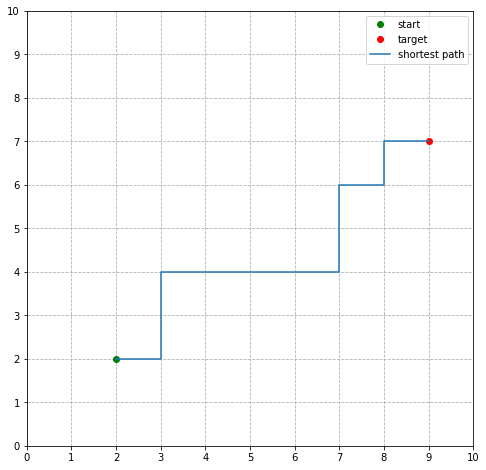

In [ ]:
def generate_candidates(x, y):
    return [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]

def calculate_distance(a, b):
    # manhattan distance
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def return_best(actual, target, i):
    k = generate_candidates(*actual)
    distances = [calculate_distance(ki, target) for ki in k]
    min_d = min(distances)

    # 1 or 2 best knighbors can occurs
    best_k = [loc for loc,val in enumerate(distances) if val == min_d]

    # Stair path
    if len(best_k) > 1:
        best_ki = k[best_k[i%2]]
    else:
        best_ki = k[best_k[-1]]

    best_ki = k[best_k[0]]  # L path
    best_ki = k[best_k[-1]]  # L path

    best_ki = k[np.random.choice(best_k)]

    return best_ki


limits = 10
start = (2, 2)
target = (9, 7)

walk = [start]
i = 0
while(True):
    walk += [return_best(walk[-1], target, i)]
    i += 1
    if walk[-1] == target: break
walk = np.array(walk)

plt.figure(figsize=(8,8))
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.xticks(range(limits+1))
plt.yticks(range(limits+1))
plt.plot(start[0], start[1], 'og', label="start")
plt.plot(target[0], target[1], 'or', label="target")
plt.plot(walk[:,0], walk[:,1], label='shortest path')  # plot greedy walk
plt.legend()
plt.grid(linestyle='--')

[(0, 0), (1, 1), (2, 0), (3, 1), (4, 2), (5, 1), (6, 0), (7, 1), (8, 0), (9, 1), (10, 0), (11, 1), (12, 2), (13, 1), (14, 0), (15, 1), (16, 0), (17, 1), (18, 2), (19, 1), (20, 0), (21, 1), (22, 2), (23, 3), (24, 4), (25, 5), (26, 4), (27, 3), (28, 2), (29, 1), (30, 2), (31, 3), (32, 2), (33, 1), (34, 0), (35, 1), (36, 2), (37, 3), (38, 4), (39, 5), (40, 4), (41, 5), (42, 4), (43, 5), (44, 4), (45, 5), (46, 4), (47, 3), (48, 2), (49, 3), (50, 2), (51, 3), (52, 4), (53, 3), (54, 2), (55, 3), (56, 2), (57, 1), (58, 2), (59, 3), (60, 2), (61, 3), (62, 2), (63, 1), (64, 0), (65, 1), (66, 0), (67, 1), (68, 2), (69, 1), (70, 0), (71, 1), (72, 2), (73, 3), (74, 2), (75, 3), (76, 4), (77, 5), (78, 6), (79, 7), (80, 6), (81, 7), (82, 6), (83, 5), (84, 6), (85, 5), (86, 6), (87, 7), (88, 8), (89, 7), (90, 6), (91, 7), (92, 6), (93, 5), (94, 6), (95, 7), (96, 8), (97, 7), (98, 8), (99, 7), (100, 8), (101, 9), (102, 10)]


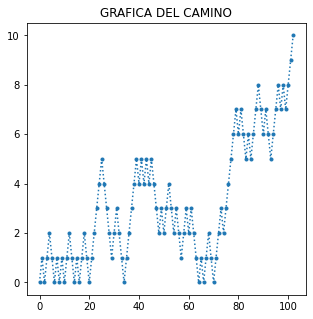

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

posiciones=[(0,0)]
actual=(0,0)
pasos = 0   #DEFINE EL NUMERO DE PASOS

while (actual[1]<10):
    if(actual[1]==0):
        step=1
    else:
        step = random.randint(0, 1)
    if(step==0):
        actual=(actual[0]+1,actual[1]-1)
        posiciones.append(actual)
    else:
        actual=(actual[0]+1,actual[1]+1)
        posiciones.append(actual)
print (posiciones)

w = np.array(posiciones).T
plt.figure(figsize=(5,5))
plt.title('GRAFICA DEL CAMINO')
plt.plot(w[0], w[1], ':.')